In [ ]:
# # ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air/notebooks')

# # Verify you're in the right place
# !pwd
# !ls -la

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
df = pd.read_csv("03 Result Data Cleaning Part 3.csv")
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.set_index('Tanggal')
df = df[['Katulampa (air)', 'Katulampa (cuaca)', 'Depok (air)', 'Depok (cuaca)', 'Manggarai (air)', 'Manggarai (cuaca)']]
df.head()

,Katulampa (air),Katulampa (cuaca),Depok (air),Depok (cuaca),Manggarai (air),Manggarai (cuaca)
Tanggal,,,,,,
2021-10-16 00:00:00,10.0,Mendung,80.0,Terang,555.0,Terang
2021-10-16 01:00:00,10.0,Mendung Tipis,95.0,Terang,555.0,Terang
2021-10-16 02:00:00,10.0,Mendung Tipis,95.0,Terang,555.0,Terang
2021-10-16 03:00:00,10.0,Mendung Tipis,90.0,Terang,555.0,Terang
2021-10-16 04:00:00,10.0,Mendung Tipis,90.0,Terang,560.0,Terang


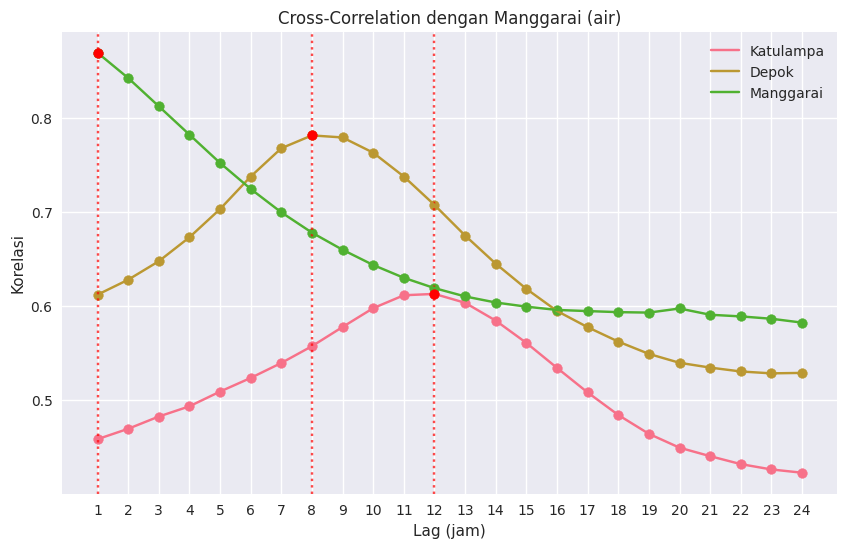

In [5]:
max_lag = 24
cross_corr = {}

for col in ["Katulampa (air)", "Depok (air)", "Manggarai (air)"]:
    corr_lags = []
    for lag in range(1, max_lag+1):
        shifted = df[col].shift(lag)
        corr = shifted.corr(df['Manggarai (air)'])
        corr_lags.append((lag, corr))
    cross_corr[col] = corr_lags

plt.figure(figsize=(10, 6))

for col in ["Katulampa (air)", "Depok (air)", "Manggarai (air)"]:
    lags, corrs = zip(*cross_corr[col])
    plt.plot(lags, corrs, label=col.replace(" (air)", ""))
    plt.scatter(lags, corrs)

    # Highlight maximum correlation point
    max_idx = corrs.index(max(corrs))
    max_lag = lags[max_idx]
    max_corr = corrs[max_idx]
    plt.axvline(x=max_lag, color="red", linestyle=":", alpha=0.7)
    plt.scatter([max_lag], [max_corr], color="red", zorder=5)

# Add guideline for every one lag
plt.xticks(lags)

plt.title("Cross-Correlation dengan Manggarai (air)")
plt.xlabel("Lag (jam)")
plt.ylabel("Korelasi")
plt.legend()
plt.show()

In [6]:
# Create new dataframe for lagged features
lagged_data = pd.DataFrame(index=df.index)

# Target variable (current Manggarai)
lagged_data['Manggarai'] = df['Manggarai (air)']

# Autoregressive lags for Manggarai (1, 2, 3 hours back)
lagged_data['Manggarai Lag 1'] = df['Manggarai (air)'].shift(1)
lagged_data['Manggarai Lag 2'] = df['Manggarai (air)'].shift(2)
lagged_data['Manggarai Lag 3'] = df['Manggarai (air)'].shift(3)

# Cross-correlation lags for Depok (7, 8, 9 hours back)
lagged_data['Depok Lag 7'] = df['Depok (air)'].shift(7)
lagged_data['Depok Lag 8'] = df['Depok (air)'].shift(8)
lagged_data['Depok Lag 9'] = df['Depok (air)'].shift(9)

# Cross-correlation lags for Katulampa (11, 12, 13 hours back)
lagged_data['Katulampa Lag 11'] = df['Katulampa (air)'].shift(11)
lagged_data['Katulampa Lag 12'] = df['Katulampa (air)'].shift(12)
lagged_data['Katulampa Lag 13'] = df['Katulampa (air)'].shift(13)

In [7]:
lagged_data.head()

,Manggarai,Manggarai Lag 1,Manggarai Lag 2,Manggarai Lag 3,Depok Lag 7,Depok Lag 8,Depok Lag 9,Katulampa Lag 11,Katulampa Lag 12,Katulampa Lag 13
Tanggal,,,,,,,,,,
2021-10-16 00:00:00,555.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-16 01:00:00,555.0,555.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-16 02:00:00,555.0,555.0,555.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-16 03:00:00,555.0,555.0,555.0,555.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-16 04:00:00,560.0,555.0,555.0,555.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Check for missing values (due to shifting)
print(f'Lagged Data Shape: {lagged_data.shape}\n')
print('Missing values due to shifting:')
print(lagged_data.isnull().sum())

Lagged Data Shape: (31224, 10)

Missing values due to shifting:
Manggarai            0
Manggarai Lag 1      1
Manggarai Lag 2      2
Manggarai Lag 3      3
Depok Lag 7          7
Depok Lag 8          8
Depok Lag 9          9
Katulampa Lag 11    11
Katulampa Lag 12    12
Katulampa Lag 13    13
dtype: int64


In [15]:
# Remove rows with missing values (caused by lagging)
lagged_data_clean = lagged_data.dropna()
print(f"After removing missing values: {lagged_data_clean.shape}")
lagged_data_clean.head()

After removing missing values: (31211, 10)


,Manggarai,Manggarai Lag 1,Manggarai Lag 2,Manggarai Lag 3,Depok Lag 7,Depok Lag 8,Depok Lag 9,Katulampa Lag 11,Katulampa Lag 12,Katulampa Lag 13
Tanggal,,,,,,,,,,
2021-10-16 13:00:00,570.0,570.0,565.0,560.0,85.0,85.0,90.0,10.0,10.0,10.0
2021-10-16 14:00:00,570.0,570.0,570.0,565.0,85.0,85.0,85.0,10.0,10.0,10.0
2021-10-16 15:00:00,570.0,570.0,570.0,570.0,80.0,85.0,85.0,10.0,10.0,10.0
2021-10-16 16:00:00,570.0,570.0,570.0,570.0,80.0,80.0,85.0,10.0,10.0,10.0
2021-10-16 17:00:00,570.0,570.0,570.0,570.0,80.0,80.0,80.0,10.0,10.0,10.0


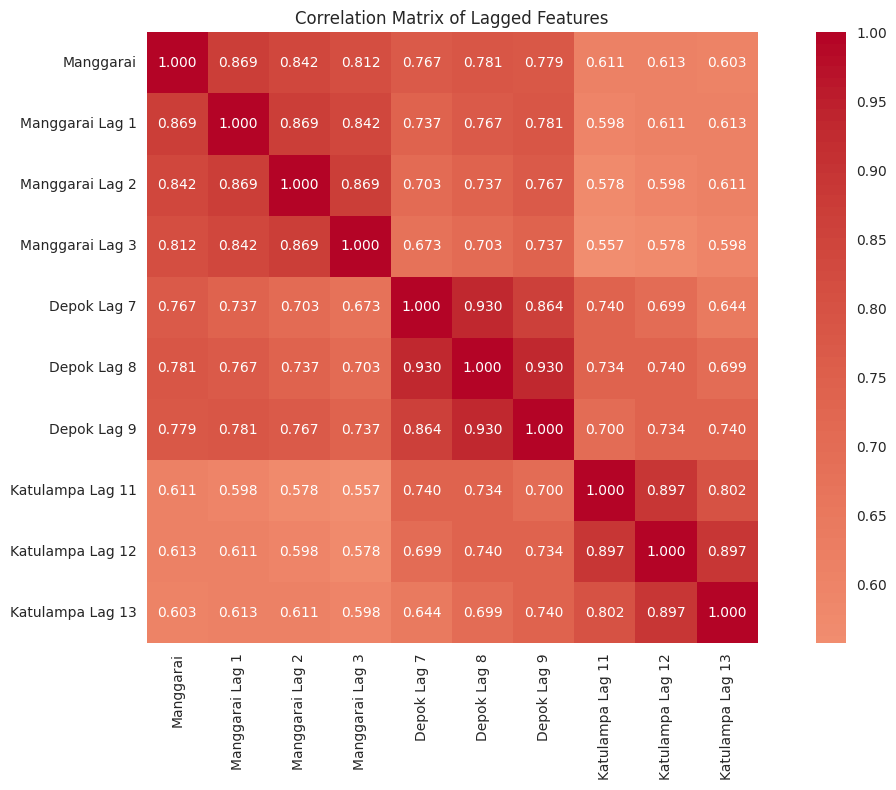

In [17]:
# Correlation matrix of the lagged features
plt.figure(figsize=(12, 8))
correlation_matrix = lagged_data_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True)
plt.title('Correlation Matrix of Lagged Features')
plt.tight_layout()
plt.show()

In [19]:
lagged_data_clean.to_csv('06_lagged_dataset.csv')

In [10]:
weather_groups = df.groupby('Manggarai (cuaca)')['Manggarai (air)'].apply(list)

# Perform ANOVA
f_stat, p_value = f_oneway(*weather_groups)
print(f"F-statistic: {f_stat}, p-value: {p_value}")

# Get water level data for each weather category
weather_groups = [group['Manggarai (air)'].values for name, group in df.groupby('Manggarai (cuaca)')]
weather_names = [name for name, group in df.groupby('Manggarai (cuaca)')]

# Perform Tukey's HSD
tukey_result = tukey_hsd(*weather_groups)
print(tukey_result)


F-statistic: 541.2950081835153, p-value: 0.0
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.620     0.860    -9.835     4.595
 (0 - 2)      0.739     0.989    -3.479     4.958
 (0 - 3)     13.155     0.000     9.143    17.167
 (0 - 4)     30.186     0.000    26.385    33.987
 (1 - 0)      2.620     0.860    -4.595     9.835
 (1 - 2)      3.359     0.622    -3.149     9.868
 (1 - 3)     15.775     0.000     9.398    22.152
 (1 - 4)     32.806     0.000    26.560    39.052
 (2 - 0)     -0.739     0.989    -4.958     3.479
 (2 - 1)     -3.359     0.622    -9.868     3.149
 (2 - 3)     12.416     0.000     9.885    14.947
 (2 - 4)     29.447     0.000    27.266    31.627
 (3 - 0)    -13.155     0.000   -17.167    -9.143
 (3 - 1)    -15.775     0.000   -22.152    -9.398
 (3 - 2)    -12.416     0.000   -14.947    -9.885
 (3 - 4)     17.031     0.000    15.282    18.780
 (4 - 0)    -30.186     0.000   -33.9

In [15]:
# Check what weather categories we have
print("=== Weather Categories ===")
print("Unique weather categories:")
print(df['Manggarai (cuaca)'].unique())
print("\nWeather category counts:")
print(df['Manggarai (cuaca)'].value_counts())

# Group water levels by weather category
weather_grouped = df.groupby('Manggarai (cuaca)')['Manggarai (air)']
weather_groups = [group.values for name, group in weather_grouped]

print(f"\n=== Mean Water Levels by Weather ===")
weather_means = weather_grouped.agg(['mean', 'count']).round(2)
print(weather_means)

# Perform ANOVA
print(f"\n=== ANOVA Results ===")
f_stat, p_value = f_oneway(*weather_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Result: Reject H0 - Weather significantly affects water levels")
    
    # Perform Tukey's HSD post hoc test with proper labels
    print(f"\n=== Post Hoc Analysis (Tukey's HSD) ===")
    tukey = pairwise_tukeyhsd(endog=df['Manggarai (air)'], 
                              groups=df['Manggarai (cuaca)'], 
                              alpha=0.05)
    print(tukey)
else:
    print("Result: Fail to reject H0 - No significant effect")

=== Weather Categories ===
Unique weather categories:
['Terang' 'Mendung' 'Hujan' 'Gerimis' 'Mendung Tipis']

Weather category counts:
Manggarai (cuaca)
Terang           20243
Mendung Tipis     6054
Mendung           3518
Gerimis           1037
Hujan              372
Name: count, dtype: int64

=== Mean Water Levels by Weather ===
                     mean  count
Manggarai (cuaca)               
Gerimis            649.53   1037
Hujan              652.15    372
Mendung            648.79   3518
Mendung Tipis      636.38   6054
Terang             619.34  20243

=== ANOVA Results ===
F-statistic: 541.2950
p-value: 0.0
Result: Reject H0 - Weather significantly affects water levels

=== Post Hoc Analysis (Tukey's HSD) ===
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------
      Gerimis         Hujan   2.6202 0.8597  -4.5948   9.8352  False

In [16]:
from scipy.stats import kruskal

# Kruskal-Wallis test (non-parametric ANOVA)
weather_groups = [group['Manggarai (air)'].values for name, group in df.groupby('Manggarai (cuaca)')]
h_stat, p_value = kruskal(*weather_groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
print(f"p-value: {p_value}")

Kruskal-Wallis H-statistic: 2420.9241
p-value: 0.0


In [18]:
import scikit_posthocs as sp

# Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='Manggarai (air)', 
                               group_col='Manggarai (cuaca)', 
                               p_adjust='bonferroni')
print("=== Dunn's Test Results ===")
print(dunn_results)

=== Dunn's Test Results ===
                     Gerimis         Hujan       Mendung  Mendung Tipis  \
Gerimis         1.000000e+00  1.000000e+00  1.000000e+00   3.075424e-15   
Hujan           1.000000e+00  1.000000e+00  1.000000e+00   6.934984e-08   
Mendung         1.000000e+00  1.000000e+00  1.000000e+00   1.480742e-45   
Mendung Tipis   3.075424e-15  6.934984e-08  1.480742e-45   1.000000e+00   
Terang         2.303522e-104  4.070341e-43  0.000000e+00  2.234281e-179   

                      Terang  
Gerimis        2.303522e-104  
Hujan           4.070341e-43  
Mendung         0.000000e+00  
Mendung Tipis  2.234281e-179  
Terang          1.000000e+00  


In [ ]:
df = pd.read_csv("03 Result Data Cleaning Part 3.csv")
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.set_index('Tanggal')
df =  df[['Katulampa (air)', 'Katulampa (cuaca)', 'Depok (air)', 'Depok (cuaca)', 'Manggarai (air)', 'Manggarai (cuaca)']]
print(f"\n{'='*60}\nY Data (Water Levels) Sample:\n{'='*60}")
print(data_y.head())

# Read weather data (X variables - weather conditions)
data_x = df[['Katulampa (cuaca)', 'Depok (cuaca)', 'Manggarai (cuaca)']].copy()
print(f"\n{'='*60}\nX Data (Weather Conditions) Sample:\n{'='*60}")
print(data_x.head())

# Check unique weather conditions
print(f"\n{'='*60}\nUnique Weather Conditions per Location:\n{'='*60}")
for col in data_x.columns:
    unique_values = data_x[col].unique()
    print(f"{col}: {unique_values}")

# Separate train and test data (95% train, 5% test)
split_index = int(len(data_y) * 0.95)

# Split data
data_y_train = data_y[:split_index]
data_y_test = data_y[split_index:]

data_x_train = data_x[:split_index]
data_x_test = data_x[split_index:]

# # Split X data and apply one-hot encoding
# data_x_train = pd.get_dummies(data_x[:split_index], drop_first=False)
# data_x_test = pd.get_dummies(data_x[split_index:], drop_first=False)

# # Find columns that end with 'Terang'
# terang_columns = [col for col in data_x_train.columns if col.endswith('Terang')]

# data_x_train = data_x_train.drop(columns=terang_columns, errors='ignore')
# data_x_test = data_x_test.drop(columns=terang_columns, errors='ignore')

# # Ensure test set has same columns as train set
# data_x_test = data_x_test.reindex(columns=data_x_train.columns, fill_value=0)

# Print data distribution information
print(f"\n{'='*60}\nData Train and Test Distribution:\n{'='*60}")
print(f'Jumlah data total: {len(data_y)}')
print(f'Jumlah data train: {len(data_y_train)} ({len(data_y_train)/len(data_y)*100:.1f}%)')
print(f'Jumlah data test: {len(data_y_test)} ({len(data_y_test)/len(data_y)*100:.1f}%)')

return data_x_train, data_x_test, data_y_train, data_y_test

In [6]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data()

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [7]:
data_y_train.head()

,Katulampa (air),Depok (air),Manggarai (air)
Tanggal,,,
2021-10-16 00:00:00,10.0,80.0,555.0
2021-10-16 01:00:00,10.0,95.0,555.0
2021-10-16 02:00:00,10.0,95.0,555.0
2021-10-16 03:00:00,10.0,90.0,555.0
2021-10-16 04:00:00,10.0,90.0,560.0


In [8]:
data_x_train.head()

,Katulampa (cuaca),Depok (cuaca),Manggarai (cuaca)
Tanggal,,,
2021-10-16 00:00:00,Mendung,Terang,Terang
2021-10-16 01:00:00,Mendung Tipis,Terang,Terang
2021-10-16 02:00:00,Mendung Tipis,Terang,Terang
2021-10-16 03:00:00,Mendung Tipis,Terang,Terang
2021-10-16 04:00:00,Mendung Tipis,Terang,Terang


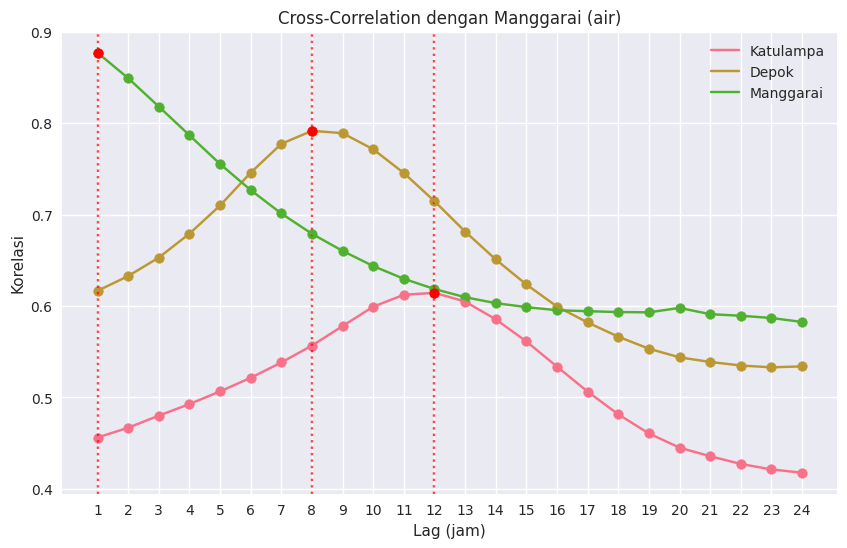

In [19]:
max_lag = 24
cross_corr = {}

for col in ["Katulampa (air)", "Depok (air)", "Manggarai (air)"]:
    corr_lags = []
    for lag in range(1, max_lag+1):
        shifted = data_y_train[col].shift(lag)
        corr = shifted.corr(data_y_train['Manggarai (air)'])
        corr_lags.append((lag, corr))
    cross_corr[col] = corr_lags

plt.figure(figsize=(10, 6))

for col in ["Katulampa (air)", "Depok (air)", "Manggarai (air)"]:
    lags, corrs = zip(*cross_corr[col])
    plt.plot(lags, corrs, label=col.replace(" (air)", ""))
    plt.scatter(lags, corrs)

    # Highlight maximum correlation point
    max_idx = corrs.index(max(corrs))
    max_lag = lags[max_idx]
    max_corr = corrs[max_idx]
    plt.axvline(x=max_lag, color="red", linestyle=":", alpha=0.7)
    plt.scatter([max_lag], [max_corr], color="red", zorder=5)

# Add guideline for every one lag
plt.xticks(lags)

plt.title("Cross-Correlation dengan Manggarai (air)")
plt.xlabel("Lag (jam)")
plt.ylabel("Korelasi")
plt.legend()
plt.show()

In [10]:
lag_range = range(1, 13)
cuaca_cols = ["Katulampa (cuaca)", "Depok (cuaca)", "Manggarai (cuaca)"]

# Make lagged categorical variables
lagged_cuaca = pd.DataFrame(index=data_x_train.index)
for col in cuaca_cols:
    for lag in lag_range:
        lagged_cuaca[f"{col}_t-{lag}"] = data_x_train[col].shift(lag)

# One hot encoding
lagged_cuaca_oh = pd.get_dummies(lagged_cuaca, drop_first=False)

# Drop all 'Terang' category
terang_cols = [col for col in lagged_cuaca_oh.columns if col.endswith('Terang')]
lagged_cuaca_oh = lagged_cuaca_oh.drop(columns=terang_cols, errors='ignore')

# Sync index
target = data_y_train["Manggarai (air)"].iloc[max(lag_range):]
lagged_cuaca_oh = lagged_cuaca_oh.iloc[max(lag_range):]

# Count mutual information
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(lagged_cuaca_oh, target, discrete_features=True)
mi_df = pd.DataFrame({
    "feature": lagged_cuaca_oh.columns,
    "mutual_information": mi_scores
}).sort_values(by="mutual_information", ascending=False)

mi_df

,feature,mutual_information
110,Manggarai (cuaca)_t-4_Mendung,0.031460
118,Manggarai (cuaca)_t-6_Mendung,0.030272
122,Manggarai (cuaca)_t-7_Mendung,0.029782
90,Depok (cuaca)_t-11_Mendung,0.028754
114,Manggarai (cuaca)_t-5_Mendung,0.028367
...,...,...
33,Katulampa (cuaca)_t-9_Hujan,0.001710
3,Katulampa (cuaca)_t-1_Mendung Tipis,0.001623
9,Katulampa (cuaca)_t-3_Hujan,0.001304
13,Katulampa (cuaca)_t-4_Hujan,0.001010


In [ ]:
lag_range = range(1, 13)
cuaca_cols = ["Katulampa (cuaca)", "Depok (cuaca)", "Manggarai (cuaca)"]
weather_map = {
    "Terang": "Terang",
    "Mendung Tipis": "Terang",
    "Mendung": "Mendung",
    "Gerimis": "Hujan",
    "Hujan": "Hujan"
}

# Make lagged categorical variables
data_x_train_reduced = data_x_train.copy()
lagged_cuaca = pd.DataFrame(index=data_x_train_reduced.index)
for col in cuaca_cols:
    data_x_train_reduced[col] = data_x_train_reduced[col].map(weather_map)
    data_x_test[col] = data_x_test[col].map(weather_map)
    for lag in lag_range:
        lagged_cuaca[f"{col}_t-{lag}"] = data_x_train_reduced[col].shift(lag)



# One hot encoding
lagged_cuaca_oh = pd.get_dummies(lagged_cuaca, drop_first=False)

# Drop all 'Terang' category
terang_cols = [col for col in lagged_cuaca_oh.columns if col.endswith('Terang')]
lagged_cuaca_oh = lagged_cuaca_oh.drop(columns=terang_cols, errors='ignore')

# Sync index
target = data_y_train["Manggarai (air)"].iloc[max(lag_range):]
lagged_cuaca_oh = lagged_cuaca_oh.iloc[max(lag_range):]

# Count mutual information
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(lagged_cuaca_oh, target, discrete_features=True)
mi_df = pd.DataFrame({
    "feature": lagged_cuaca_oh.columns,
    "mutual_information": mi_scores
}).sort_values(by="mutual_information", ascending=False)

mi_df

,feature,mutual_information
22,Katulampa (cuaca)_t-12_Hujan,0.035340
67,Manggarai (cuaca)_t-10_Mendung,0.030490
55,Manggarai (cuaca)_t-4_Mendung,0.029592
20,Katulampa (cuaca)_t-11_Hujan,0.028616
45,Depok (cuaca)_t-11_Mendung,0.028396
...,...,...
50,Manggarai (cuaca)_t-2_Hujan,0.011512
1,Katulampa (cuaca)_t-1_Mendung,0.011296
28,Depok (cuaca)_t-3_Hujan,0.010643
0,Katulampa (cuaca)_t-1_Hujan,0.010101


In [21]:
data_x_train

,Katulampa (cuaca)_t-1_Gerimis,Katulampa (cuaca)_t-1_Hujan,Katulampa (cuaca)_t-1_Mendung,Katulampa (cuaca)_t-1_Mendung Tipis,Katulampa (cuaca)_t-1_Terang,Katulampa (cuaca)_t-2_Gerimis,Katulampa (cuaca)_t-2_Hujan,Katulampa (cuaca)_t-2_Mendung,Katulampa (cuaca)_t-2_Mendung Tipis,Katulampa (cuaca)_t-2_Terang,...,Manggarai (cuaca)_t-11_Gerimis,Manggarai (cuaca)_t-11_Hujan,Manggarai (cuaca)_t-11_Mendung,Manggarai (cuaca)_t-11_Mendung Tipis,Manggarai (cuaca)_t-11_Terang,Manggarai (cuaca)_t-12_Gerimis,Manggarai (cuaca)_t-12_Hujan,Manggarai (cuaca)_t-12_Mendung,Manggarai (cuaca)_t-12_Mendung Tipis,Manggarai (cuaca)_t-12_Terang
Tanggal,,,,,,,,,,,,,,,,,,,,,
2021-10-16 12:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2021-10-16 13:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2021-10-16 14:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2021-10-16 15:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2021-10-16 16:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-04 17:00:00,False,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,False
2025-03-04 18:00:00,False,False,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
2025-03-04 19:00:00,False,False,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
